#**ANALISIS SENTIMEN PENGGUNA TERHADAP WONDR BNI DI PLAY STORE**

#Instalasi Library


In [1]:
!pip install sastrawi
!pip install tensorflow
!pip install scikit-learn
!pip install pandas nltk wordcloud requests matplotlib seaborn
!pip install lightgbm xgboost catboost
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.9 MB/s eta 0:00:00


#Impor Library


In [40]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import requests
import json
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import time
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Dataset

In [4]:
df = pd.read_csv('/content/hasil_screeping_wondrBNI.csv', encoding='utf-8', quotechar='"', escapechar='\\')
# Membaca file CSV dari URL ke dalam DataFrame pandas

df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score
0,"Sering banget eror, sering banget perbaikan da...",1
1,Kenapa data yg kita masukkan gak ter save. Set...,1
2,Terimakasih sudah ada menu total pengeluaran/p...,4
3,"Baru download karena disarankan cs bank, pada ...",1
4,"Nah suruh migrasi tapi belum siap, tarik tunai...",1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Cleaning

In [6]:
clean_df = df.dropna()


In [7]:
clean_df = clean_df.drop_duplicates()


In [8]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17133 entries, 0 to 19068
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  17133 non-null  object
 1   score    17133 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 401.6+ KB


In [9]:
clean_df.head()


,content,score
0,"Sering banget eror, sering banget perbaikan da...",1
1,Kenapa data yg kita masukkan gak ter save. Set...,1
2,Terimakasih sudah ada menu total pengeluaran/p...,4
3,"Baru download karena disarankan cs bank, pada ...",1
4,"Nah suruh migrasi tapi belum siap, tarik tunai...",1


#Pra-pemrosesan Teks (Text Preprocessing)

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in ["mobile", "bni", "wondr", "bni mobile"]])
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [11]:
url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/slangwords.json'

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)


In [15]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [16]:
clean_df.head()


,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Sering banget eror, sering banget perbaikan da...",1,Sering banget eror sering banget perbaikan dan...,sering banget eror sering banget perbaikan dan...,sering banget error sering banget perbaikan da...,"[sering, banget, error, sering, banget, perbai...","[banget, error, banget, perbaikan, buka, lamba...",banget error banget perbaikan buka lambat bang...
1,Kenapa data yg kita masukkan gak ter save. Set...,1,Kenapa data yg kita masukkan gak ter save Seti...,kenapa data yg kita masukkan gak ter save seti...,kenapa data yang kita masukkan tidak ter save ...,"[kenapa, data, yang, kita, masukkan, tidak, te...","[data, masukkan, ter, save, transaksi, token, ...",data masukkan ter save transaksi token pln lai...
2,Terimakasih sudah ada menu total pengeluaran/p...,4,Terimakasih sudah ada menu total pengeluaranpe...,terimakasih sudah ada menu total pengeluaranpe...,terimakasih sudah ada menu total pengeluaranpe...,"[terimakasih, sudah, ada, menu, total, pengelu...","[terimakasih, menu, total, pengeluaranpemasuka...",terimakasih menu total pengeluaranpemasukan de...
3,"Baru download karena disarankan cs bank, pada ...",1,Baru download karena disarankan cs bank pada s...,baru download karena disarankan cs bank pada s...,baru download karena disarankan cs bank pada s...,"[baru, download, karena, disarankan, cs, bank,...","[download, disarankan, cs, bank, log, aman, ja...",download disarankan cs bank log aman jam pakai...
4,"Nah suruh migrasi tapi belum siap, tarik tunai...",1,Nah suruh migrasi tapi belum siap tarik tunai ...,nah suruh migrasi tapi belum siap tarik tunai ...,nah suruh migrasi tapi belum siap tarik tunai ...,"[nah, suruh, migrasi, tapi, belum, siap, tarik...","[suruh, migrasi, tarik, tunai, atm, pembayaran...",suruh migrasi tarik tunai atm pembayaran qris ...


#Pelabelan dan Ekstraksi Fitur

In [17]:
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            parts = line.split(',')
            word = ','.join(parts[:-1])
            score = parts[-1]
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

positive_lexicon_url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/LeksikonPositif.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/aninanandah/datasetproject/main/LeksikonNegatif.txt'

# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [18]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [19]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)


results = list(zip(*results))

clean_df['polarity_score'] = results[0]

clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
positive    7196
negative    7134
neutral     2803
Name: count, dtype: int64


In [20]:
X = clean_df['text_akhir']
y = clean_df['polarity']

#Ekstraksi Fitur

In [21]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

In [22]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,akses,akun,aman,aneh,apapun,aplikasi,aplikasinya,app,apps,atm,...,transfer,tunai,uang,ui,ulang,update,user,verifikasi,warna,wonder
0,0.0,0.0,0.000000,0.0,0.0,0.126987,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.238433
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.244214,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.166827,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.189601,0.0,0.0,0.081337,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.188556,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.247199,...,0.0,0.20272,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17128,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
17129,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
17130,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
17131,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


#**Data Visualization**

#Presentase Polaritas

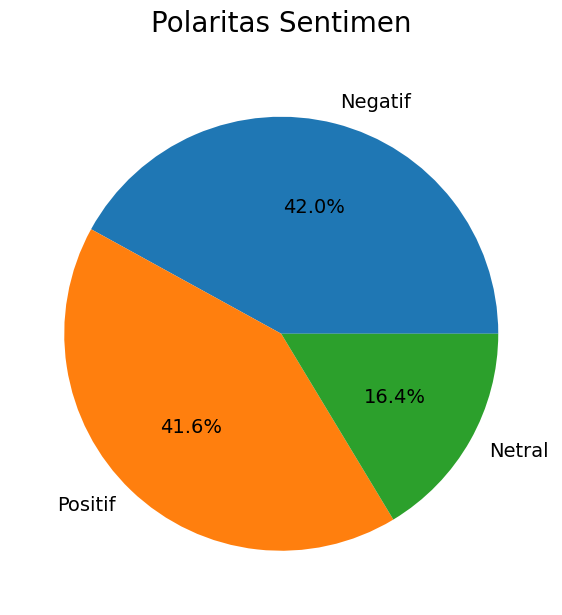

In [23]:
fig, ax = plt.subplots(figsize=(7, 8))
sizes = [count for count in clean_df['polarity'].value_counts()]
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral']
explode = (0, 0, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22)
plt.show()

#Word Cloud

In [24]:
positive_review = clean_df[clean_df['polarity'] == 'positive']
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [25]:
negative_review = clean_df[clean_df['polarity'] == 'negative']
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [26]:
neutral_review = clean_df[clean_df['polarity'] == 'neutral']
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

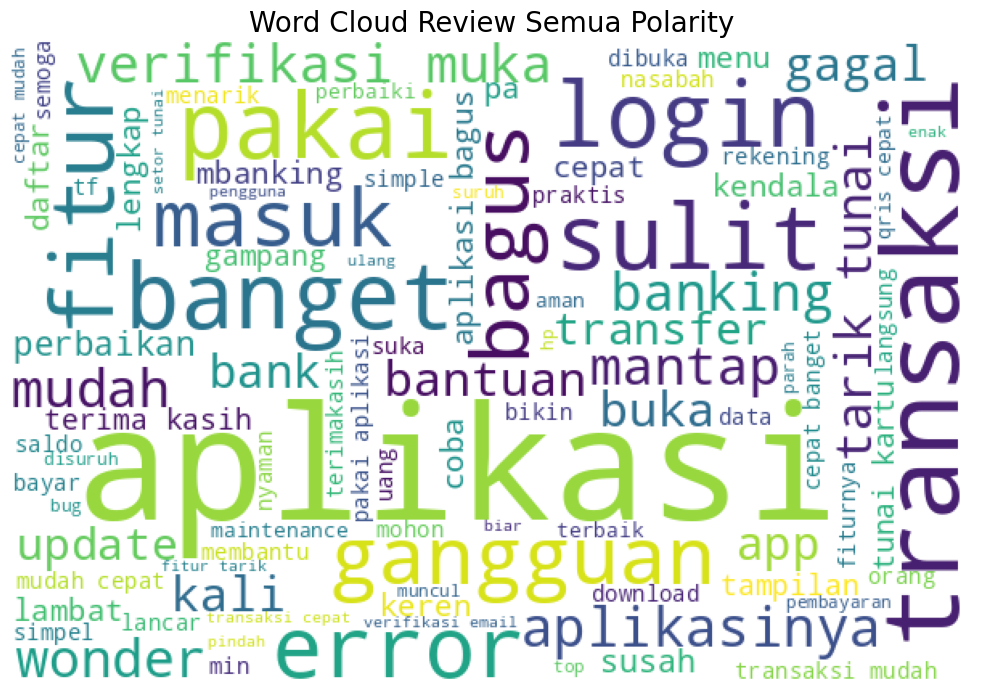

In [27]:
list_words = ''
for tweet in clean_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Semua Polarity', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

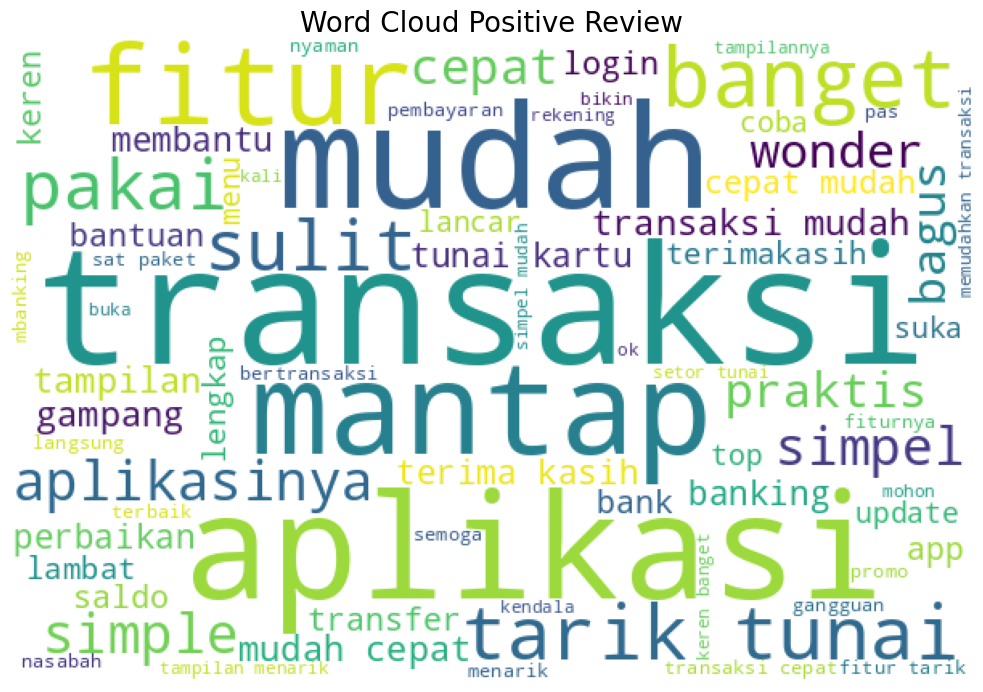

In [28]:
list_words = ''
for review in positive_review['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Positive Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

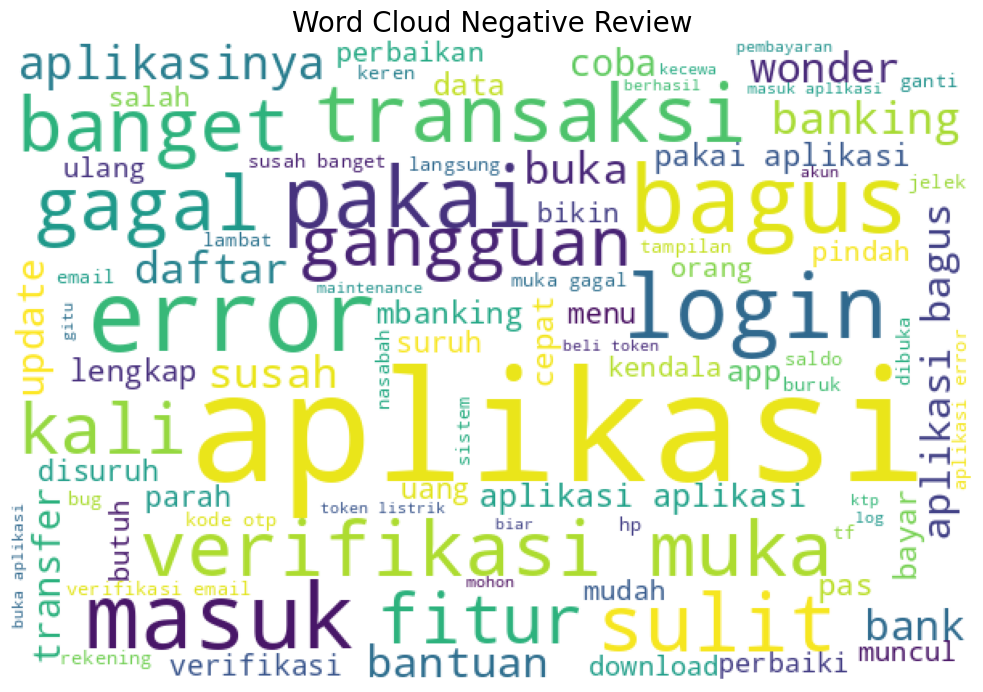

In [29]:
list_words = ''
for review in negative_review['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Negative Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

#Distribusi Kelas

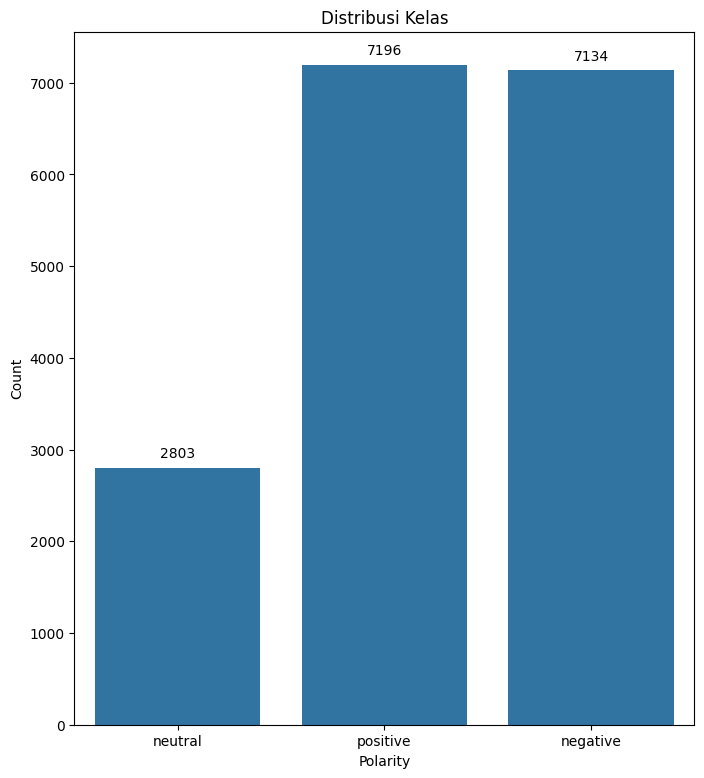

In [30]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

#Pemodelan

#Data Splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)

#LogisticRegression

In [32]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8799066102436889
Logistic Regression - accuracy_test: 0.882112634957689


#XGBoost

In [33]:
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')

XGBoost - accuracy_train: 0.9124471034583395
XGBoost - accuracy_test: 0.8707324190253867
XGBoost - execution_time: 24.169267654418945 seconds


#CatBoost

In [34]:
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')


CatBoost - accuracy_train: 0.8809280607033416
CatBoost - accuracy_test: 0.8666472133060986
CatBoost - execution_time: 11.576054096221924 seconds


# SVM

In [35]:
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.8810010214504597
SVM - accuracy_test: 0.8768602276043187
SVM - execution_time: 12.325612306594849 seconds


#Perbandingan Akurasi Model

In [36]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression','Support Vector Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_svm, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model','Accuracy Train', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                       Model  Accuracy Train  Accuracy Test
0        Logistic Regression        0.879907       0.882113
1     Support Vector Machine        0.881001       0.876860
2  Extreme Gradient Boosting        0.912447       0.870732
3       Categorical Boosting        0.880928       0.866647


#Kesimpulan

In [41]:
# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [38]:
# Simpan TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [39]:
!pip freeze > requirements.txt